In [30]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import jax
import jax_cosmo as jc
import jax.numpy as np
from DifferentiableHOS.Plot import plot_contours
cosmo_jax = jc.Planck15()

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [31]:
ps_array=[]
jac_array=[]
for i in (range(9)):
    results_dict = pickle.load( open( "/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/result"+str(i)+".pkl", "rb" ) )
    ps=results_dict['ps']
    jac=results_dict['jac']
    ps_array.append(ps)
    jac_array.append(jac)
ell=results_dict['ell']

In [32]:
ps_mean=np.mean(np.stack(ps_array),axis=0)
jac_mean=np.mean(np.stack(jac_array),axis=0)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


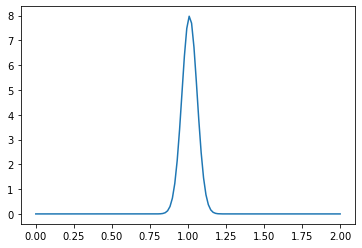

In [33]:
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
plot(zsamp, nzs_s(zsamp))
nzs = [nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]
cls = jc.angular_cl.angular_cl(cosmo_jax, ell, probes)


# we compute the covariance matrix using the tools from the Jax module
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_jax, ell, probes,f_sky=25/41252, sparse=True);

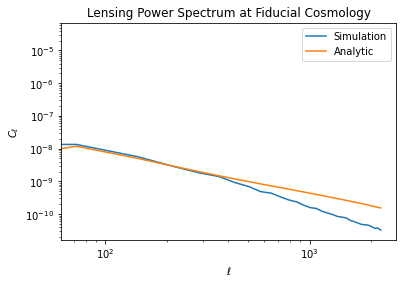

In [43]:
loglog(ell,  ps_mean, label='Simulation')
loglog(ell, mu, label='Analytic')
title('Lensing Power Spectrum at Fiducial Cosmology')
legend()
xlabel(r"$\ell$")
ylabel(r"$C_\ell$")
savefig('power_spectrum_norm_64_all.png',dpi=175)

In [34]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, probes)
  return m.flatten()
params=np.array([0.2589,0.8159]) 
jac_mean_the = jax.jit(jax.jacfwd(mean_fn))
dmu = jac_mean_the(params)

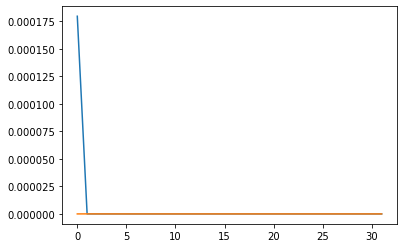

In [7]:
plot(jac_mean[:,0])
plot(dmu[:, 0])

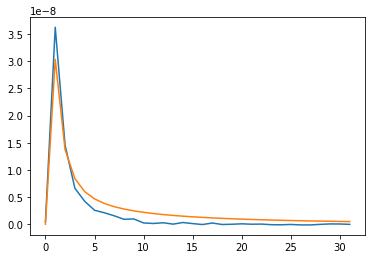

In [8]:
plot(jac_mean[:,1])
plot(dmu[:, 1])

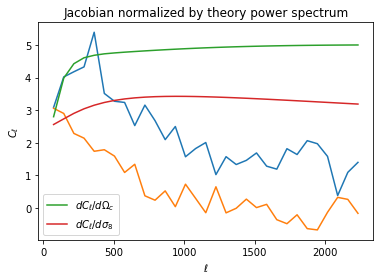

In [36]:
plot(ell, jac_mean[:,0]/mu)
plot(ell, jac_mean[:,1]/mu)
plot(ell, dmu[:,0]/mu,label=r'${d C_{\ell}}/{d \Omega_c}$')
plot(ell, dmu[:,1]/mu, label=r'${d C_{\ell}}/{d \sigma_8}$')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()
title('Jacobian normalized by theory power spectrum')
savefig('psnorm_64.png',dpi=175)

In [12]:
jac1=jac[2:]

In [13]:
cls = jc.angular_cl.angular_cl(cosmo_jax, ell[2:], probes)
mu_red, cov_red = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_jax, ell[2:], probes,f_sky=25/41252, sparse=True);
def mean_fn_red(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell[2:], probes)
  return m.flatten()
params=np.array([0.2589,0.8159]) 
jac_mean_red = jax.jit(jax.jacfwd(mean_fn_red))
dmu1 = jac_mean_red(params)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


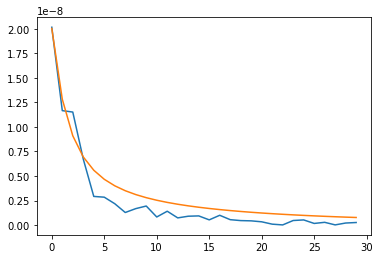

In [14]:
# We compare the Jax and the TensorFlow Jacobian for both the cosmological parameters
plot(jac1[:,0])
plot(dmu1[:, 0])

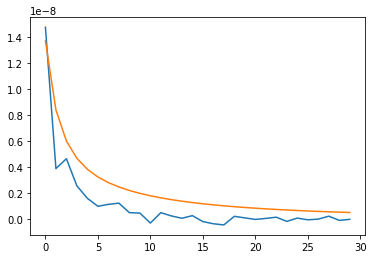

In [15]:
plot(jac1[:,1])
plot(dmu1[:, 1])

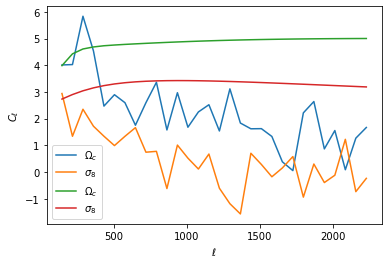

In [18]:
plot(ell[2:], jac1[:,0]/mu_red, label='$\Omega_c$ ')
plot(ell[2:], jac1[:,1]/mu_red, label='$\sigma_8$ ')
plot(ell[2:], dmu1[:,0]/mu_red, label='$\Omega_c$ ')
plot(ell[2:], dmu1[:,1]/mu_red, label='$\sigma_8$ ')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()

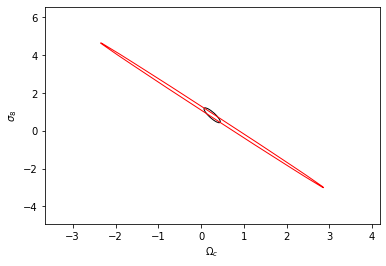

In [40]:
F = jc.sparse.dot(jac1.T, jc.sparse.inv(cov_red), jac1)
F_jax=jc.sparse.dot(dmu1.T, jc.sparse.inv(cov_red), dmu1)
plot_contours(F, params, fill=False,color='black',lw=1);
plot_contours(F_jax, params, fill=False,color='red',lw=1);
xlabel('$\Omega_c$')
ylabel('$\sigma_8$');
savefig('Fisher_32.png',dpi=175)

In [25]:
F_jax

DeviceArray([[196.70485, 133.93   ],
             [133.93001,  91.25677]], dtype=float32)

In [29]:
inv(F_jax)

array([[ 6.8083434, -9.992041 ],
       [-9.992043 , 14.67545  ]], dtype=float32)